# 💳 대출 승인 예측 - 의사결정나무 실습 (문제용)

이 노트북은 Kaggle Loan Approval Prediction Dataset(`loan.csv`)을 사용해
의사결정나무(Decision Tree)를 학습/평가/해석하는 방법을 연습합니다.

사용 컬럼 (loan.csv):
- loan_id
- no_of_dependents
- education (문자열: Graduate / Not Graduate 등)
- self_employed (Yes / No 등)
- income_annum (연간 소득)
- loan_amount (대출 금액)
- loan_term (상환 기간)
- cibil_score (신용 점수)
- residential_assets_value, commercial_assets_value,
  luxury_assets_value, bank_asset_value (자산 가치 지표들)
- loan_status (0=거절, 1=승인) ← 타깃 변수

학습 목표
1. 데이터 확인 & 전처리 (결측치 처리, 인코딩)
2. 학습/테스트 분리
3. 결정트리 학습 및 시각화
4. 정확도/혼동행렬로 성능 평가
5. 특성 중요도(Feature Importance) 해석
6. max_depth에 따른 과적합/일반화 비교

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

sns.set(style="whitegrid")
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 1. 데이터 로드
df = pd.read_csv("../data/08_loan_approval_dataset.csv")
df.head()

,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


## 1️⃣ 데이터 구조 파악
- `df.shape`, `df.info()`, `df.head()`로 데이터 구조를 확인하세요.
- `loan_status` 값의 분포(`value_counts()`)를 출력하고 승인/거절의 불균형 여부를 설명하세요.

In [2]:
# TODO: df.shape, df.info(), df.head(), loan_status 분포 시각화
print(df.shape)
df.info()
df.head()

(4269, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4269 entries, 0 to 4268
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   loan_id                    4269 non-null   int64 
 1    no_of_dependents          4269 non-null   int64 
 2    education                 4269 non-null   object
 3    self_employed             4269 non-null   object
 4    income_annum              4269 non-null   int64 
 5    loan_amount               4269 non-null   int64 
 6    loan_term                 4269 non-null   int64 
 7    cibil_score               4269 non-null   int64 
 8    residential_assets_value  4269 non-null   int64 
 9    commercial_assets_value   4269 non-null   int64 
 10   luxury_assets_value       4269 non-null   int64 
 11   bank_asset_value          4269 non-null   int64 
 12   loan_status               4269 non-null   object
dtypes: int64(10), object(3)
memory usage: 433.7+ KB


,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


In [3]:
df.columns  

Index(['loan_id', ' no_of_dependents', ' education', ' self_employed',
       ' income_annum', ' loan_amount', ' loan_term', ' cibil_score',
       ' residential_assets_value', ' commercial_assets_value',
       ' luxury_assets_value', ' bank_asset_value', ' loan_status'],
      dtype='object')

In [4]:
df[' loan_status'].value_counts() #승인 2656, 거절 1613건으로 약간의 불균형

 loan_status
Approved    2656
Rejected    1613
Name: count, dtype: int64

## 2️⃣ 결측치 처리
- 각 컬럼의 결측치 개수를 출력하세요: `df.isnull().sum()`
- 결측치 처리 규칙(학습용 간단 버전):
  - `education`, `self_employed` 처럼 범주형(object)은 최빈값(mode)으로 채운다.
  - 나머지 수치형(int/float)은 중앙값(median)으로 채운다.
- 결측치 처리 후 다시 `isnull().sum()`으로 확인하세요.

In [5]:
# TODO:
# df.isnull().sum() 출력 후 df_prep 생성, mode()/median()으로 결측치 채우기
df.isnull().sum()

loan_id                      0
 no_of_dependents            0
 education                   0
 self_employed               0
 income_annum                0
 loan_amount                 0
 loan_term                   0
 cibil_score                 0
 residential_assets_value    0
 commercial_assets_value     0
 luxury_assets_value         0
 bank_asset_value            0
 loan_status                 0
dtype: int64

In [6]:
cate_cols = [' education', ' self_employed']
num_cols = ['loan_id', ' no_of_dependents', ' income_annum', ' loan_amount', ' loan_term', ' cibil_score',
            ' residential_assets_value', ' commercial_assets_value', ' luxury_assets_value', ' bank_asset_value']

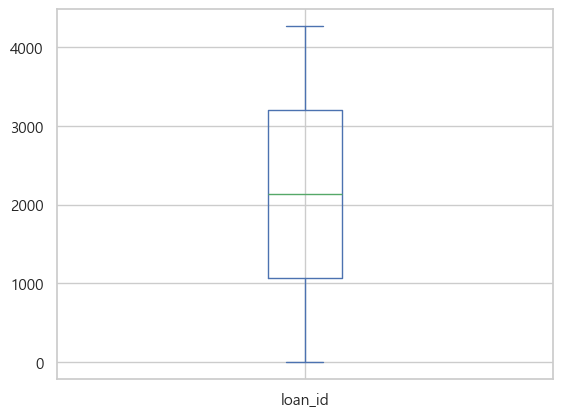

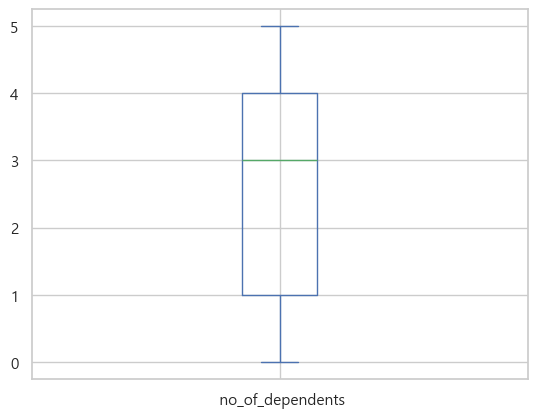

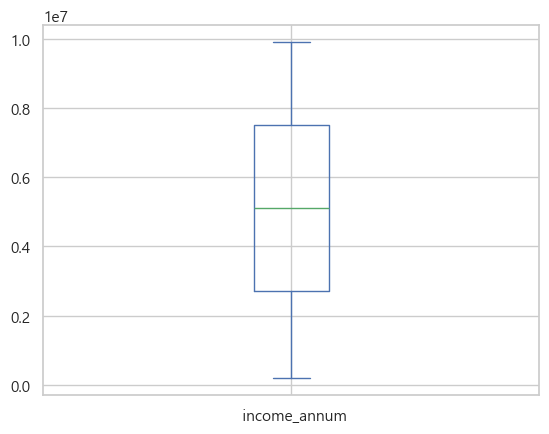

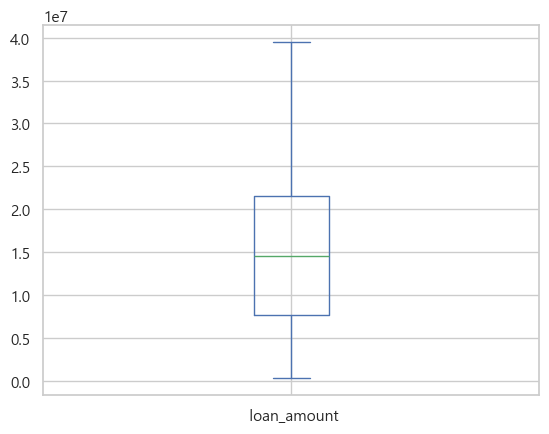

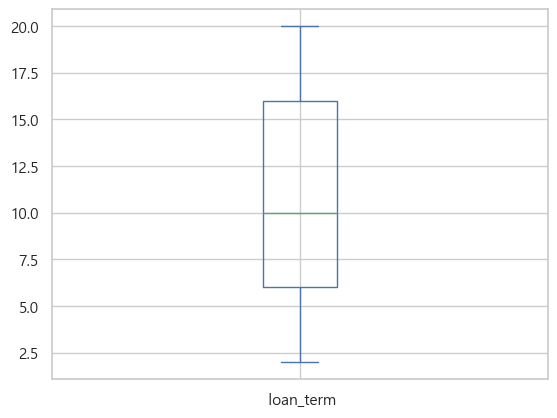

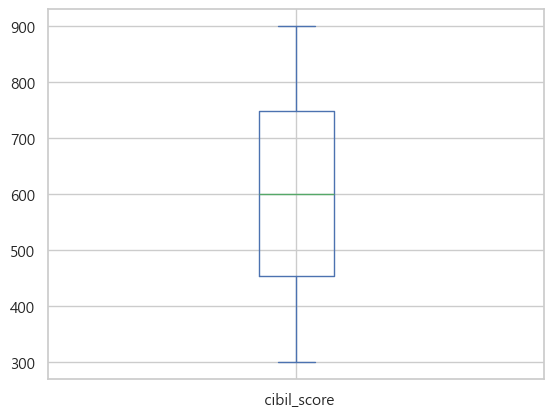

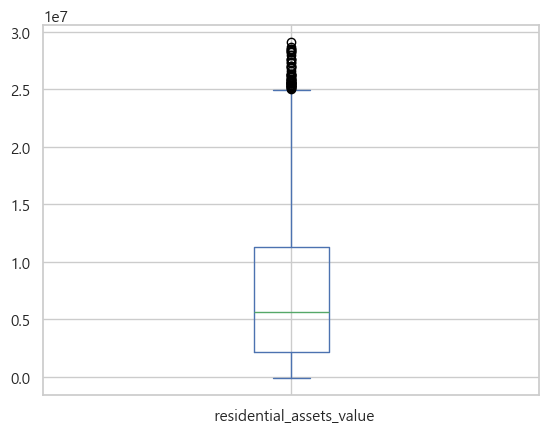

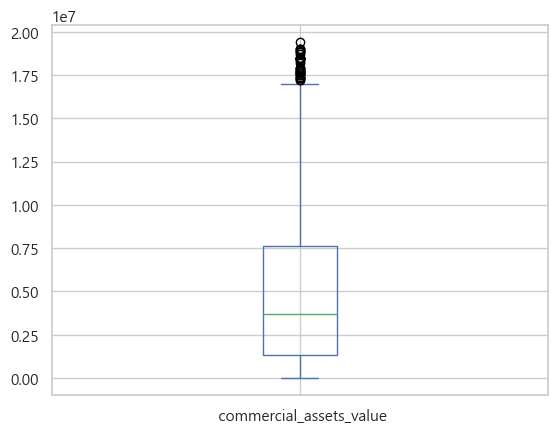

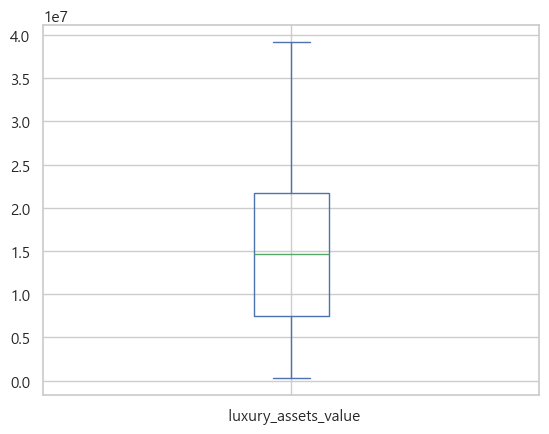

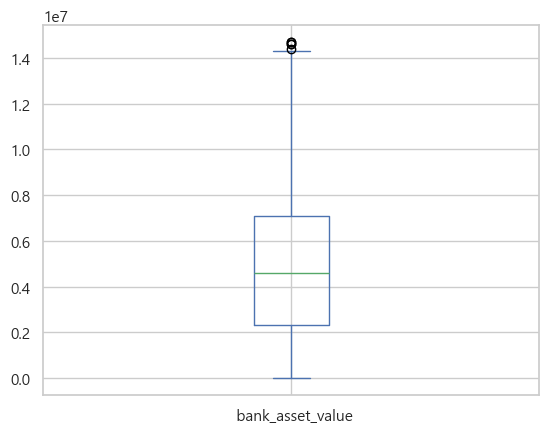

In [7]:
for col in ['loan_id', ' no_of_dependents', ' income_annum', ' loan_amount', ' loan_term', ' cibil_score', ' residential_assets_value', ' commercial_assets_value', ' luxury_assets_value', ' bank_asset_value']:
    df[col].plot(kind='box')
    plt.show()
# ' residential_assets_value', ' commercial_assets_value', ' bank_asset_value' => 이상치 확인

In [8]:
df[num_cols] = df[num_cols].fillna(df[num_cols].median())
df[num_cols]

,loan_id,no_of_dependents,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value
0,1,2,9600000,29900000,12,778,2400000,17600000,22700000,8000000
1,2,0,4100000,12200000,8,417,2700000,2200000,8800000,3300000
2,3,3,9100000,29700000,20,506,7100000,4500000,33300000,12800000
3,4,3,8200000,30700000,8,467,18200000,3300000,23300000,7900000
4,5,5,9800000,24200000,20,382,12400000,8200000,29400000,5000000
...,...,...,...,...,...,...,...,...,...,...
4264,4265,5,1000000,2300000,12,317,2800000,500000,3300000,800000
4265,4266,0,3300000,11300000,20,559,4200000,2900000,11000000,1900000
4266,4267,2,6500000,23900000,18,457,1200000,12400000,18100000,7300000
4267,4268,1,4100000,12800000,8,780,8200000,700000,14100000,5800000


In [9]:
df[cate_cols] = df[cate_cols].fillna(df[cate_cols].mode())
df[cate_cols]

,education,self_employed
0,Graduate,No
1,Not Graduate,Yes
2,Graduate,No
3,Graduate,No
4,Not Graduate,Yes
...,...,...
4264,Graduate,Yes
4265,Not Graduate,Yes
4266,Not Graduate,No
4267,Not Graduate,No


In [10]:
df.isnull().sum()

loan_id                      0
 no_of_dependents            0
 education                   0
 self_employed               0
 income_annum                0
 loan_amount                 0
 loan_term                   0
 cibil_score                 0
 residential_assets_value    0
 commercial_assets_value     0
 luxury_assets_value         0
 bank_asset_value            0
 loan_status                 0
dtype: int64

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4269 entries, 0 to 4268
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   loan_id                    4269 non-null   int64 
 1    no_of_dependents          4269 non-null   int64 
 2    education                 4269 non-null   object
 3    self_employed             4269 non-null   object
 4    income_annum              4269 non-null   int64 
 5    loan_amount               4269 non-null   int64 
 6    loan_term                 4269 non-null   int64 
 7    cibil_score               4269 non-null   int64 
 8    residential_assets_value  4269 non-null   int64 
 9    commercial_assets_value   4269 non-null   int64 
 10   luxury_assets_value       4269 non-null   int64 
 11   bank_asset_value          4269 non-null   int64 
 12   loan_status               4269 non-null   object
dtypes: int64(10), object(3)
memory usage: 433.7+ KB


## 3️⃣ 범주형 인코딩
- `education`, `self_employed`는 문자열 → 숫자로 변환해야 합니다.
- LabelEncoder를 사용하여 이 두 컬럼을 정수로 바꾸세요.
- 인코딩된 결과를 `df_encoded.head()`로 확인하세요.

=> But! 나는 OneHotEncoder 배웠기에 이걸 사용하겠음.

In [22]:
from sklearn.preprocessing import LabelEncoder

# LabelEncoder 객체 생성
encoder = LabelEncoder()

# 복사본 만들기 (원본 df 손상 방지)
df_encoded = df.copy()

# 각 범주형 컬럼에 대해 인코딩 수행
for col in [' education', ' self_employed']:
    df_encoded[col] = encoder.fit_transform(df_encoded[col])

# 결과 확인
df_encoded.head()

,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,0,0,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,1,1,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,0,0,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,0,0,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,1,1,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


In [23]:
df_encoded.head()

,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,0,0,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,1,1,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,0,0,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,0,0,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,1,1,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


## 4️⃣ 학습/테스트 분리
- 설명변수 X는 `loan_status`를 제외한 나머지 컬럼입니다.
- 타깃 y는 `loan_status`입니다.
- `train_test_split`으로 학습 80%, 테스트 20%로 나누세요 (`random_state=42`, `stratify=y`).
- X_train, X_test의 shape를 출력하세요.

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

In [29]:
# TODO:
# train_test_split 후 shape 출력
X = df_encoded.drop(' loan_status', axis=1)
y = df_encoded[' loan_status']

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10, stratify=y)
print(X_train.shape)
print(X_test.shape)

(3415, 12)
(854, 12)


## 5️⃣ 결정트리 학습 및 과적합 확인
- `DecisionTreeClassifier(random_state=42)`로 모델을 학습하세요.
- `DecisionTreeClassifier(max_depth=3, random_state=42)` 모델도 학습하세요.
- 각 모델에 대해 학습 정확도(train acc)와 테스트 정확도(test acc)를 비교하세요.
- 가지치기(max_depth 제한)가 과적합을 줄였는지 해석하세요.

In [20]:
# TODO:
# full tree와 max_depth=3 tree의 학습/테스트 정확도를 비교
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

In [31]:
# 1. 가지치기 없는 모델
tree_full = DecisionTreeClassifier(random_state=42)
tree_full.fit(X_train, y_train)

# 예측
y_pred_train_full = tree_full.predict(X_train)
y_pred_test_full = tree_full.predict(X_test)

# 정확도
train_acc_full = accuracy_score(y_train, y_pred_train_full)
test_acc_full = accuracy_score(y_test, y_pred_test_full)

print("가지치기 없는 모델")
print("Train Accuracy:", train_acc_full)
print("Test Accuracy:", test_acc_full)

가지치기 없는 모델
Train Accuracy: 1.0
Test Accuracy: 0.9648711943793911


In [32]:
# 2. 가지치기된 모델
tree_limited = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_limited.fit(X_train, y_train)

# 예측
y_pred_train_limited = tree_limited.predict(X_train)
y_pred_test_limited = tree_limited.predict(X_test)

# 정확도
train_acc_limited = accuracy_score(y_train, y_pred_train_limited)
test_acc_limited = accuracy_score(y_test, y_pred_test_limited)

print("\n가지치기된 모델 (max_depth=3)")
print("Train Accuracy:", train_acc_limited)
print("Test Accuracy:", test_acc_limited)


가지치기된 모델 (max_depth=3)
Train Accuracy: 0.9651537335285505
Test Accuracy: 0.9601873536299765


## 6️⃣ 결정트리 시각화
- `plot_tree(tree_limited, ...)`로 가지치기된 트리를 시각화하세요.
- `feature_names=X.columns`, `class_names=['Reject','Approve']` 형태로 표시하세요.
- 루트 노드 분기 기준이 되는 변수는 무엇이며, 그게 실제 대출 심사에서 왜 중요할까요?

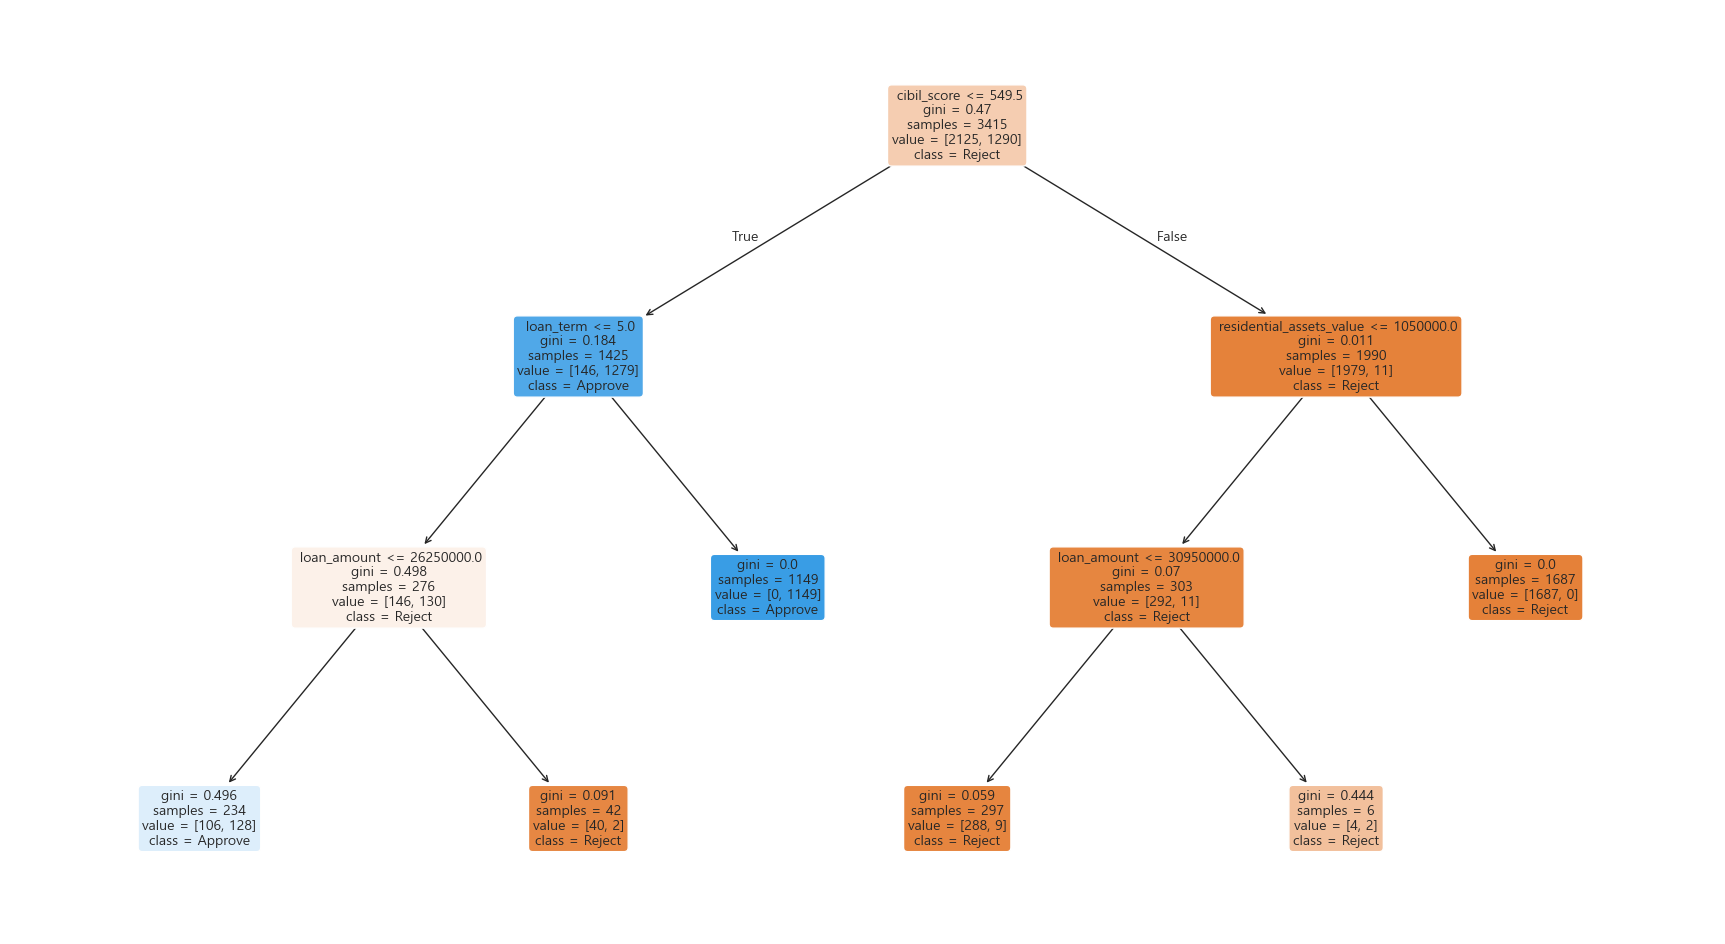

In [34]:
# TODO:
# plot_tree로 tree_limited 시각화 후 첫 분기 변수 해석
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from sklearn import tree
import numpy as np
import pandas as pd

plt.figure(figsize=(22, 12))
tree.plot_tree(tree_limited, filled = True, rounded=True, fontsize=10, feature_names=X.columns, class_names=['Reject','Approve'])
plt.show()

* 기준: cibil_score(신용점수) 
* 중요성: 신용점수 낮으면 상환 불이행 위험 높아 승인 가능성 낮아짐

## 7️⃣ 모델 평가 (혼동행렬 & 리포트)
- `tree_limited` 모델로 테스트셋을 예측하세요 (y_pred).
- `classification_report`와 `confusion_matrix`를 출력하세요.
- 어떤 오류가 더 치명적인지 설명하세요:
  - 승인해야 할 고객을 거절로 예측한 경우?
  - 거절해야 할 고객을 승인으로 예측한 경우?

In [35]:
# TODO:
# classification_report / confusion_matrix 출력 후 비즈니스 관점에서 해석
# 테스트셋 예측
y_pred = tree_limited.predict(X_test)

# 성능 평가
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

    Approved       0.99      0.94      0.97       531
    Rejected       0.91      0.99      0.95       323

    accuracy                           0.96       854
   macro avg       0.95      0.97      0.96       854
weighted avg       0.96      0.96      0.96       854

Confusion Matrix:
 [[500  31]
 [  3 320]]


## 8️⃣ 변수 중요도 (Feature Importance)
- `tree_limited.feature_importances_`를 이용해 변수 중요도를 계산하세요.
- barplot으로 내림차순 시각화하세요.
- 상위 중요한 변수 3개를 골라서, 금융적으로 납득이 되는지 서술하세요
  (예: cibil_score가 높을수록 승인될 가능성이 높다 → 신용점수 중요).

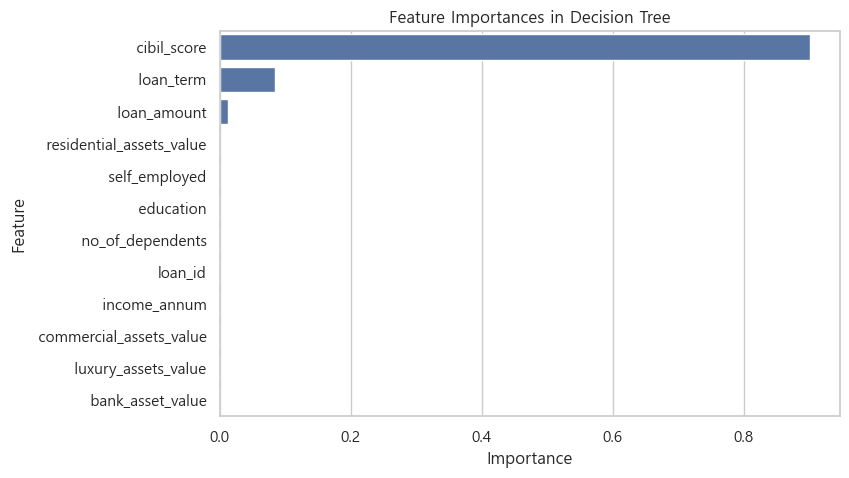

Top 3 important features:
cibil_score    0.901697
loan_term      0.084985
loan_amount    0.012856
dtype: float64


In [36]:
# TODO:
# feature_importances_ 시각화 및 상위 3개 변수 해석
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 변수 중요도 계산
feature_importances = pd.Series(tree_limited.feature_importances_, index=X.columns)

# 내림차순 정렬
feature_importances = feature_importances.sort_values(ascending=False)

# 시각화
plt.figure(figsize=(8,5))
sns.barplot(x=feature_importances.values, y=feature_importances.index)
plt.title('Feature Importances in Decision Tree')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# 상위 3개 변수 출력
print("Top 3 important features:")
print(feature_importances.head(3))

## 9️⃣ 가지치기(Pruning) 실험
- max_depth를 1~6으로 바꿔가며 모델을 학습하세요.
- 각 깊이에 대해 테스트 정확도를 기록하세요.
- (x=깊이, y=정확도) 선 그래프로 시각화하세요.
- 깊이가 커질수록 어떤 패턴(과적합/일반화 변화)이 나타나는지 해석하세요.

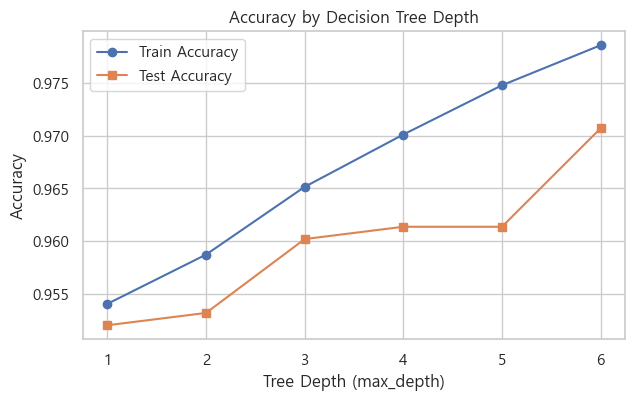

In [37]:
# TODO:
# max_depth별 accuracy를 그려보고 과적합/일반화 경향 설명
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

train_acc = []
test_acc = []

# 깊이를 1~6까지 변경하며 학습
for depth in range(1, 7):
    model = DecisionTreeClassifier(max_depth=depth, random_state=42)
    model.fit(X_train, y_train)
    
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    
    train_acc.append(accuracy_score(y_train, train_pred))
    test_acc.append(accuracy_score(y_test, test_pred))

# 시각화
plt.figure(figsize=(7,4))
plt.plot(range(1,7), train_acc, marker='o', label='Train Accuracy')
plt.plot(range(1,7), test_acc, marker='s', label='Test Accuracy')
plt.title('Accuracy by Decision Tree Depth')
plt.xlabel('Tree Depth (max_depth)')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

max_depth가 커질수록 학습 데이터에 대한 정확도는 계속 상승하지만,
일정 깊이 이후부터는 테스트 정확도가 오히려 떨어지며 과적합(overfitting) 이 발생합니다.
따라서 모델의 일반화 성능을 유지하려면 적절한 깊이(예: 3~4 수준) 에서 가지치기를 적용하는 것이 좋습니다.

## 🔟 비즈니스/핀테크 관점 해석 (서술형)
- 트리의 첫 분기(루트 노드)는 무엇인가요? 이건 어떤 리스크 판단 기준을 시사하나요?
- 잘못 승인(회수 불가능 위험) vs 잘못 거절(매출 기회 상실) 중 어떤 게 금융기관 입장에서 더 치명적인가요?
- 실제 핀테크 심사 서비스에 이 트리를 그대로 쓰려면 어떤 공정성·설명가능성(Explainability) 이슈가 있나요?

_여기에 본인 해석을 작성하세요._

---
🎉 완료!
이제 금융(대출 승인) 데이터를 이용해 전처리 → 모델 학습 → 평가 → 해석 → 리스크 논의까지 한 번에 경험했습니다.
